In [1]:
!git clone https://github.com/AlwaysSearching/DeepDoubleDescent_Tensorflow

Cloning into 'DeepDoubleDescent_Tensorflow'...
remote: Enumerating objects: 561, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 561 (delta 8), reused 18 (delta 8), pack-reused 541
Receiving objects: 100% (561/561), 309.99 MiB | 28.17 MiB/s, done.
Resolving deltas: 100% (262/262), done.
Checking out files: 100% (459/459), done.


In [2]:
!nvidia-smi

Sun Apr 18 04:44:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

import os
os.chdir("DeepDoubleDescent_Tensorflow")

from utils.train_utils import train_resnet18
from utils.visualizations import plot_loss_from_file, plot_loss_vs_epoch_from_file, load_results

# keeps tensorflow from using all available GPU memory when a model is initialized.
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.keras.backend.clear_session()

print("Executed")

Executed


In [ ]:
########### IMPORTANT ####################
# This is crashing the colab notebook
# Even lost the previous work due to this 
# Only try running this before saving previous work
# Did not try running this in GCP

from utils.train_utils import train_conv_nets
data_set = 'cifar100'
#Assigned: 13-16, 20, 48-56
covnet_widths_fig7 = [i for i in range(17)]+[20+(4*i) for i in range(12)]

print("\nTraining CovNet on CIFAR-100 with 0 Label Noise for 500 epochs - Recreating figure 7\n")

label_noise = 0
"""
metrics_noise0_rohin = list()
metrics_noise0_rohin = train_conv_nets(
    data_set=data_set,
    resnet_widths=resnet_widths_rohin,
    label_noise_as_int=label_noise,
    n_epochs=1000
)"""

metrics_fig7 = train_conv_nets(
    data_set=data_set,
    convnet_depth=5,
    convnet_widths=covnet_widths_fig7,
    label_noise_as_int=0,
    n_batch_steps=200_000,
    optimizer=None,
    save=True,
    data_save_path_prefix="",
    data_save_path_suffix="",
    load_saved_metrics=False
)


Training CovNet on CIFAR-100 with 0 Label Noise for 500 epochs - Recreating figure 7



In [ ]:
!pwd


/content/DeepDoubleDescent_Tensorflow


In [27]:
######## IMPORTANT ########

# No need to update load_results() in utils/visualizations.py
# But would need to update plot_loss_from_file(), implementation is giving errors
# Use plot_loss_from_file() to visualise results vs epochs

# This means use epoch as a list instead of width in plot_loss_vs_epoch_from_file()
# The axis labels will be wrong so might want to change that
# Probably would wanna remove the transpose in train_error.T in line 231,
# which is- train_im = train_plot.imshow(train_error.T, aspect="auto", origin="lower", norm=norm, interpolation="nearest")

from utils.train_utils import load_data, timer
from models.resnet import make_resnet18_UniformHe

def train_resnet18_epoch(
    data_set,
    resnet_widths,
    label_noise_as_int=10,
    n_epochs=None,
    n_batch_steps=500_000,
    optimizer=None,
    save=True,
    data_save_path_prefix="",
    data_save_path_suffix="",
    load_saved_metrics=False
):
    """
    Train and save the results of ResNets nets of a given range of model widths.

    Parameters
    ----------
    data_set: str
        Which data set to train on. See the load data funciton.
    resnet_widths: int
        Model width to train.
    label_noise_as_int: int
        Percentage of label noise to add to the training data.
    n_epochs: list[int]
        number of epochs to train as a list, if not specified, will calculate with n_batch_steps
    n_batch_steps: int
        number of gradient descent steps to take, over-ridden if n_epochs is specified
    optimizer: tf.keras.optimizer
        Optimizer to use while training resnets. Default is Adam with a learning rate of 1e-4.
    save: bool
        whether to save the data and trained model weights.
    data_save_path_prefix: str
        prefix to add to the save pkl file path.
    data_save_path_suffix: str
        suffix to add to the save pkl file name.
    load_saved_metrics: bool
        if True, will attempt to load the metrics from a previous training session in the save_path,
        to continue training from there. If True, will load the saved .pkl file instead of starting
        over and overwriting it. 
    """

    label_noise = label_noise_as_int / 100

    # load the relevent dataset
    (x_train, y_train), (x_test, y_test), image_shape = load_data(
        data_set, label_noise, augment_data=False
    )

    batch_size = 128
    n_classes = tf.math.reduce_max(y_train).numpy() + 1

    """
    # total number desirec SGD steps / number batches per epoch = n_epochs
    if not n_epochs:
        n_epochs = n_batch_steps // (x_train.shape[0] // batch_size)
	"""

    # store results for later graphing and analysis.
    model_histories = {}
    metrics = {}

    # Paths to save model weights and experimental results.
    model_weights_paths = f"trained_model_weights_epoch_{data_set}/resnet18_{label_noise_as_int}pct_noise_width_{resnet_widths}/"
    data_save_path = (
        f"experimental_results_epoch_{data_set}/resnet18_{label_noise_as_int}pct_noise_width_{resnet_widths}" + ".pkl"
    )

    # add possible path identifiers.
    if data_save_path_prefix:
        data_save_path = data_save_path_prefix + "/" + data_save_path
    if data_save_path_suffix:
        assert data_save_path[-4:] == ".pkl"
        data_save_path = data_save_path[:-4] + data_save_path_suffix + ".pkl"
    
    # load data from prior runs of related experiment.
    if load_saved_metrics:
        try:
            with open(data_save_path, 'rb') as f:
                metrics = pkl.load(f)
        except Exception as e:
            print('Could not find saved metrics.pkl file, exiting')
            raise e

        loaded_epochs = [int(i.split('_')[-1]) for i in metrics.keys()]
        assert n_epochs[:len(loaded_epochs)] == loaded_epochs
        print('loaded results for epoch %s from existing file at %s' %(', '.join([str(i) for i in loaded_epochs]), data_save_path))

        assert data_save_path[-4:] == ".pkl"
        data_backup_path = data_save_path[:-4] + 'backup_w%d_' %loaded_epochs[-1] + time.strftime("%D_%H%M%S").replace('/', '') + ".pkl"
        print('saving existing result.pkl to backup at %s' %data_backup_path)
        pkl.dump(metrics, open(data_backup_path, "wb"))

    # Resnet18 with Kaiming Uniform Initialization.
    resnet, model_id = make_resnet18_UniformHe(
        image_shape, k=resnet_widths, num_classes=n_classes
    )

    # compile and pass input to initialize parameters.
    resnet.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4)
        if optimizer is None
        else optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    resnet(tf.keras.Input(shape=list(image_shape), batch_size=batch_size))

    m_id = model_id

    for epoch in n_epochs:
        if load_saved_metrics and epoch in loaded_epochs:
            print('epoch %d results already loaded from .pkl file, training skipped' %epoch)
            continue
        
        # Different widths were recorded in model_id via make_resnet18_UniformHe().
        # Epochs would need to be mentioned in model_id to make sure the dict is accessible by number of epochs, is taken care of here
        # Make sure this is done when writing train_covnet_epoch()

        model_id = f"{m_id}_epochs_{epoch}"

        model_timer = timer()

        print(f"STARTING TRAINING: {model_id}, Label Noise: {label_noise}")
        history = resnet.fit(
            x=x_train,
            y=y_train,
            validation_data=(x_test, y_test),
            epochs=epoch,
            batch_size=batch_size,
            verbose=0,
            callbacks=[model_timer],
        )
        print(f"FINISHED TRAINING: {model_id}")

        # add results to dictionary and store the resulting model weights.
        metrics[model_id] = history.history

        # clear GPU of prior model to decrease training times.
        tf.keras.backend.clear_session()

        # Save results to the data file
        if save:
            pkl.dump(metrics, open(data_save_path, "wb"))
            history.model.save_weights(model_weights_paths + model_id)

    return metrics

print("Executed")

Executed


In [60]:
# n is number of points we need to plot to generate the graph
n = 10

# Assume the x-axis needs ~300 epochs
# Needs to be precise till ~200 epochs for a good plot
# x-axis is logarithmic

#epoch_fig16 = [(i+1)*4 for i in range(50)] +[200+(8*i) for i in range(12)] # Epochs: 8028

gap = 10**(1/n)

epoch_fig16 = [ int(gap**(i+1)) for i in range(25)]

epoch_fig16 = set(epoch_fig16)
print(epoch_fig16)
#print(set(epoch_fig16))
# Total number of epochs
print(sum(epoch_fig16))
# Each epoch takes half a minute, 25 epochs ~12 minutes
print("Hours to generate graph: ",(sum(epoch_fig16)*0.5)/60)

{1, 2, 3, 5, 6, 7, 10, 12, 15, 19, 25, 158, 31, 39, 50, 316, 63, 199, 79, 100, 251, 125}
1516
Hours to generate graph:  12.633333333333333


In [ ]:
data_set = 'cifar10'
#Assigned: 13-16, 20, 48-56
#epoch_fig16 = [i+1 for i in range(200)]+[200+(4*i) for i in range(25)]
#epoch_fig16 = [(i+1)*4 for i in range(50)] +[200+(8*i) for i in range(12)]
n=10

gap = 10**(1/n)

epoch_fig16 = [ int(gap**(i+1)) for i in range(25)]

epoch_fig16 = set(epoch_fig16)

print("\nTraining ResNet on CIFAR-10 with 20 Label Noise with width 32 for 1-300 epochs - Recreating figure 16\n")
# Doing this without data augmentation

label_noise = 0

for epoch in epoch_fig16:
  
  metrics_noise0_rohin = list()
  metrics_noise0_rohin = train_resnet18(
    data_set=data_set,
    resnet_widths=[32],
    label_noise_as_int=label_noise,
    n_epochs=epoch,
    optimizer=tf.keras.optimizers.Adam(1e-4)
  )



Training ResNet on CIFAR-10 with 20 Label Noise with width 32 for 1-300 epochs - Recreating figure 16

STARTING TRAINING: ResNet18_width_32, Label Noise: 0.0
Epoch: 0000, Total Run Time: 00:00:31 - Loss: 2.0218e+00, Accuracy: 0.346, Test Loss: 5.1091e+00, Test Accuracy: 0.154
FINISHED TRAINING: ResNet18_width_32
STARTING TRAINING: ResNet18_width_32, Label Noise: 0.0
Epoch: 0000, Total Run Time: 00:00:32 - Loss: 2.2085e+00, Accuracy: 0.342, Test Loss: 3.2100e+00, Test Accuracy: 0.148
FINISHED TRAINING: ResNet18_width_32
STARTING TRAINING: ResNet18_width_32, Label Noise: 0.0
Epoch: 0000, Total Run Time: 00:00:33 - Loss: 2.0112e+00, Accuracy: 0.374, Test Loss: 1.8859e+00, Test Accuracy: 0.370
FINISHED TRAINING: ResNet18_width_32
STARTING TRAINING: ResNet18_width_32, Label Noise: 0.0
Epoch: 0000, Total Run Time: 00:00:33 - Loss: 2.1424e+00, Accuracy: 0.327, Test Loss: 4.6552e+00, Test Accuracy: 0.190


KeyboardInterrupt: ignored

In [ ]:
import os
os.chdir("..")
!mv train_utils.py DeepDoubleDescent_Tensorflow/utils
os.chdir("DeepDoubleDescent_Tensorflow")

Timer callback isn't working, should be made better

In [28]:
import utils
#print(dir(utils.train_utils))
%load_ext autoreload
%reload_ext autoreload

import importlib
importlib.import_module("utils.train_utils")

#from utils.train_utils import train_resnet18_epoch
data_set = 'cifar10'
#Assigned: 13-16, 20, 48-56
#epoch_fig16 = [i+1 for i in range(200)]+[200+(4*i) for i in range(25)]

"""
# Estimated time for running: 44 hrs
epoch_fig16 = [(i+1)*4 for i in range(50)] +[200+(8*i) for i in range(12)] # Current estimate ~8028 epochs
"""

n=10

gap = 10**(1/n)

epoch_fig16 = [ int(gap**(i+1)) for i in range(25)]

epoch_fig16 = set(epoch_fig16)

print("\nTraining ResNet on CIFAR-10 with 20 Label Noise with width 32 for 1-300 epochs - Recreating figure 16\n")
# Doing this without data augmentation

label_noise = 0
  
metrics_noise0_rohin = list()
metrics_noise0_rohin = train_resnet18_epoch(
  data_set=data_set,
  resnet_widths=32,
  label_noise_as_int=label_noise,
  n_epochs=epoch_fig16,
  optimizer=tf.keras.optimizers.Adam(1e-4)
)

KeyboardInterrupt: ignored

In [22]:
with open("experimental_results_epoch_cifar10/resnet18_0pct_noise_width_32.pkl", 'rb') as f:
  metrics_loaded = pkl.load(f)
print(len(metrics_loaded.items()))
print(metrics_loaded['ResNet18_width_32'])
print(metrics_loaded['ResNet18_width_32'].items())
print(len(metrics_loaded['ResNet18_width_32'].items()))

1
{'loss': [0.6852884292602539, 0.6756851077079773, 0.5962361693382263, 0.6272801160812378, 0.5792248845100403, 0.44380801916122437, 0.4084590673446655, 0.3449031114578247, 0.7192893028259277, 0.3113483488559723, 0.2922412157058716, 0.3441198468208313], 'accuracy': [0.7637400031089783, 0.7697799801826477, 0.793179988861084, 0.7965999841690063, 0.8085799813270569, 0.8486400246620178, 0.8596600294113159, 0.8805000185966492, 0.8135799765586853, 0.8949800133705139, 0.904699981212616, 0.8934800028800964], 'val_loss': [5.388895034790039, 2.888650894165039, 1.2670987844467163, 2.710080862045288, 2.406886577606201, 3.8777894973754883, 2.7102694511413574, 1.3832056522369385, 1.9802799224853516, 3.9091312885284424, 2.6442079544067383, 3.713196039199829], 'val_accuracy': [0.3813000023365021, 0.4472000002861023, 0.6320000290870667, 0.44769999384880066, 0.5260999798774719, 0.3659000098705292, 0.5314000248908997, 0.6680999994277954, 0.6406000256538391, 0.4575999975204468, 0.5440999865531921, 0.42919

In [ ]:
f=open("experimental_results_epoch_cifar10/resnet18_0pct_noise_width_32.pkl", 'rb')
metrics_loaded = pkl.load(f)

In [30]:
!pwd
!zip -r ./fig16_epoch_4-36.zip ./trained_model_weights_epoch_cifar10/

/content/DeepDoubleDescent_Tensorflow
  adding: trained_model_weights_epoch_cifar10/ (stored 0%)
  adding: trained_model_weights_epoch_cifar10/resnet18_0pct_noise_width_32/ (stored 0%)
  adding: trained_model_weights_epoch_cifar10/resnet18_0pct_noise_width_32/ResNet18_width_32.data-00000-of-00001 (deflated 9%)
  adding: trained_model_weights_epoch_cifar10/resnet18_0pct_noise_width_32/ResNet18_width_32_epochs_36.index (deflated 79%)
  adding: trained_model_weights_epoch_cifar10/resnet18_0pct_noise_width_32/ResNet18_width_32_epochs_24.data-00000-of-00001 (deflated 9%)
  adding: trained_model_weights_epoch_cifar10/resnet18_0pct_noise_width_32/ResNet18_width_32_epochs_32.data-00000-of-00001 (deflated 9%)
  adding: trained_model_weights_epoch_cifar10/resnet18_0pct_noise_width_32/ResNet18_width_32_epochs_12.data-00000-of-00001 (deflated 9%)
  adding: trained_model_weights_epoch_cifar10/resnet18_0pct_noise_width_32/ResNet18_width_32.index (deflated 79%)
  adding: trained_model_weights_epoch_c

In [32]:
plot_loss_from_file("experimental_results_epoch_cifar10/resnet18_0pct_noise_width_32.pkl")

/content/DeepDoubleDescent_Tensorflow/utils/visualizations.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_losses = np.array(train_losses)
/content/DeepDoubleDescent_Tensorflow/utils/visualizations.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_accuracy = np.array(train_accuracy)
/content/DeepDoubleDescent_Tensorflow/utils/visualizations.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

AxisError: ignored

In [36]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib

import numpy as np
import pickle as pkl

from utils.visualizations import load_results

def plot_loss_from_file_epoch(path):
    """
    Function to plot the results from previous runs stored in the experimental_results folder.

    The path should point to a pickled dictionary with the following structure:
    {
        'model_id'{
            'loss': list,
            'accuracy': list,
            'val_loss': list,
            'val_accuracy': list,
            ...
        }
    }

    This is a dictionary where the key is the model id generated by the _get() function for the desired model, and
    the items being the history returned by calling model.fit().
    """

    results = load_results(path)

    widths = results.get("widths")
    train_losses = results.get("loss")
    train_accuracy = results.get("accuracy")
    test_losses = results.get("val_loss")
    test_accuracy = results.get("val_accuracy")

    # optimal early stopping values
    optimal_test_idx = test_accuracy.argmax(axis=0)
    optimal_early_train_losses = np.array(
        [train_losses[i, idx] for i, idx in enumerate(optimal_test_idx)]
    )
    optimal_early_train_accuracy = np.array(
        [train_accuracy[i, idx] for i, idx in enumerate(optimal_test_idx)]
    )
    optimal_early_test_losses = np.array(
        [test_losses[i, idx] for i, idx in enumerate(optimal_test_idx)]
    )
    optimal_early_test_accuracy = np.array(
        [test_accuracy[i, idx] for i, idx in enumerate(optimal_test_idx)]
    )

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

    train_loss_plt = axes[0][0]
    test_loss_plt = axes[0][1]
    train_accy_plt = axes[1][0]
    test_accy_plt = axes[1][1]

    mrkr_size = 2

    # plot final and optimal early stopping train loss
    train_loss_plt.plot(
        widths,
        train_losses[:, -1],
        marker="o",
        markersize=mrkr_size,
        label="Final Train Loss",
    )
    train_loss_plt.plot(
        widths,
        optimal_early_train_losses,
        marker="o",
        markersize=mrkr_size,
        label="Optimal Early Stopping Train Loss",
    )
    train_loss_plt.set_ylabel("Train Loss", fontsize=16)

    # plot final and optimal early stopping test loss
    test_loss_plt.plot(
        widths,
        test_losses[:, -1],
        marker="o",
        markersize=mrkr_size,
        label="Final Test Loss",
    )
    test_loss_plt.plot(
        widths,
        optimal_early_test_losses,
        marker="o",
        markersize=mrkr_size,
        label="Optimal Early Stopping Test Loss",
    )
    test_loss_plt.set_ylabel("Test Loss", fontsize=16)

    # plot final and optimal early stopping train error
    train_accy_plt.plot(
        widths,
        100 * (1 - train_accuracy[:, -1]),
        marker="o",
        markersize=mrkr_size,
        label="Final Train Error",
    )
    train_accy_plt.plot(
        widths,
        100 * (1 - optimal_early_train_accuracy),
        marker="o",
        markersize=mrkr_size,
        label="Optimal Early Stopping Train Accuracy",
    )
    train_accy_plt.set_ylabel("Train Error", fontsize=16)

    # plot final and optimal early stopping test error
    test_accy_plt.plot(
        widths,
        100 * (1 - test_accuracy[:, -1]),
        marker="o",
        markersize=mrkr_size,
        label="Final Test Error",
    )
    test_accy_plt.plot(
        widths,
        100 * (1 - optimal_early_test_accuracy),
        marker="o",
        markersize=mrkr_size,
        label="Optimal Early Stopping Test Error",
    )
    test_accy_plt.set_ylabel("Test Error", fontsize=16)

    for ax in axes.flatten():
        ax.set_xlabel("Epochs", fontsize=16)
        ax.legend(fontsize=14)
        ax.grid(alpha=0.5)

    fig.tight_layout(pad=1.15, h_pad=2)
    plt.show()

print("Executed")

Executed


In [37]:
plot_loss_from_file_epoch("experimental_results_epoch_cifar10/resnet18_0pct_noise_width_32.pkl")

/content/DeepDoubleDescent_Tensorflow/utils/visualizations.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_losses = np.array(train_losses)
/content/DeepDoubleDescent_Tensorflow/utils/visualizations.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_accuracy = np.array(train_accuracy)
/content/DeepDoubleDescent_Tensorflow/utils/visualizations.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

TypeError: ignored

In [39]:
with open("experimental_results_epoch_cifar10/resnet18_0pct_noise_width_32.pkl", 'rb') as f:
  metrics_loaded = pkl.load(f)
print(len(metrics_loaded.items()))
print(metrics_loaded)
print(metrics_loaded['ResNet18_width_32'].items())
print(len(metrics_loaded['ResNet18_width_32'].items()))

9
{'ResNet18_width_32_epochs_4': {'loss': [2.0128986835479736, 1.4983913898468018, 1.3433903455734253, 1.3182114362716675], 'accuracy': [0.3778199851512909, 0.475600004196167, 0.5336999893188477, 0.5486599802970886], 'val_loss': [2.088545799255371, 5.3470611572265625, 3.443983316421509, 18.84885597229004], 'val_accuracy': [0.27810001373291016, 0.11869999766349792, 0.313400000333786, 0.10159999877214432]}, 'ResNet18_width_32_epochs_8': {'loss': [1.272216558456421, 1.0914429426193237, 0.9486660957336426, 1.1112829446792603, 0.8985035419464111, 0.8151787519454956, 1.006602168083191, 1.0586433410644531], 'accuracy': [0.5729799866676331, 0.6228200197219849, 0.671720027923584, 0.652679979801178, 0.6984999775886536, 0.725600004196167, 0.6779400110244751, 0.6914799809455872], 'val_loss': [11.191983222961426, 1.8769242763519287, 4.446936130523682, 3.8409645557403564, 7.115650653839111, 1.9010838270187378, 1.7468044757843018, 1.6878949403762817], 'val_accuracy': [0.19009999930858612, 0.477600008

KeyError: ignored

In [46]:


with open("experimental_results_cifar10/resnet18_10pct_noise_alpha_1_Pres_Bathch_Norm_Results.pkl", 'rb') as f:
  metrics_loaded = pkl.load(f)
print(len(metrics_loaded.items()))
print( metrics_loaded.items() )
print(metrics_loaded)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [47]:
with open("experimental_results_cifar10/resnet18_10pct_noise_alpha_1_Pres_Bathch_Norm_Results.pkl", 'rb') as f:
  metrics_loaded = pkl.load(f)
print(len(metrics_loaded.items()))
print( metrics_loaded.items() )
print(metrics_loaded)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
# To download training weights of the 32 width resnet18 for epochs 4-36

!pwd
!unzip fig16_epoch_4-36.zip

/home/ecbm4040/DeepDoubleDescent_Tensorflow/need_to_push
Archive:  fig16_epoch_4-36.zip
   creating: trained_model_weights_epoch_cifar10/
   creating: trained_model_weights_epoch_cifar10/resnet18_0pct_noise_width_32/
  inflating: trained_model_weights_epoch_cifar10/resnet18_0pct_noise_width_32/ResNet18_width_32.data-00000-of-00001  
  inflating: trained_model_weights_epoch_cifar10/resnet18_0pct_noise_width_32/ResNet18_width_32_epochs_36.index  
  inflating: trained_model_weights_epoch_cifar10/resnet18_0pct_noise_width_32/ResNet18_width_32_epochs_24.data-00000-of-00001  
  inflating: trained_model_weights_epoch_cifar10/resnet18_0pct_noise_width_32/ResNet18_width_32_epochs_32.data-00000-of-00001  
  inflating: trained_model_weights_epoch_cifar10/resnet18_0pct_noise_width_32/ResNet18_width_32_epochs_12.data-00000-of-00001  
  inflating: trained_model_weights_epoch_cifar10/resnet18_0pct_noise_width_32/ResNet18_width_32.index  
  inflating: trained_model_weights_epoch_cifar10/resnet18_0pct_

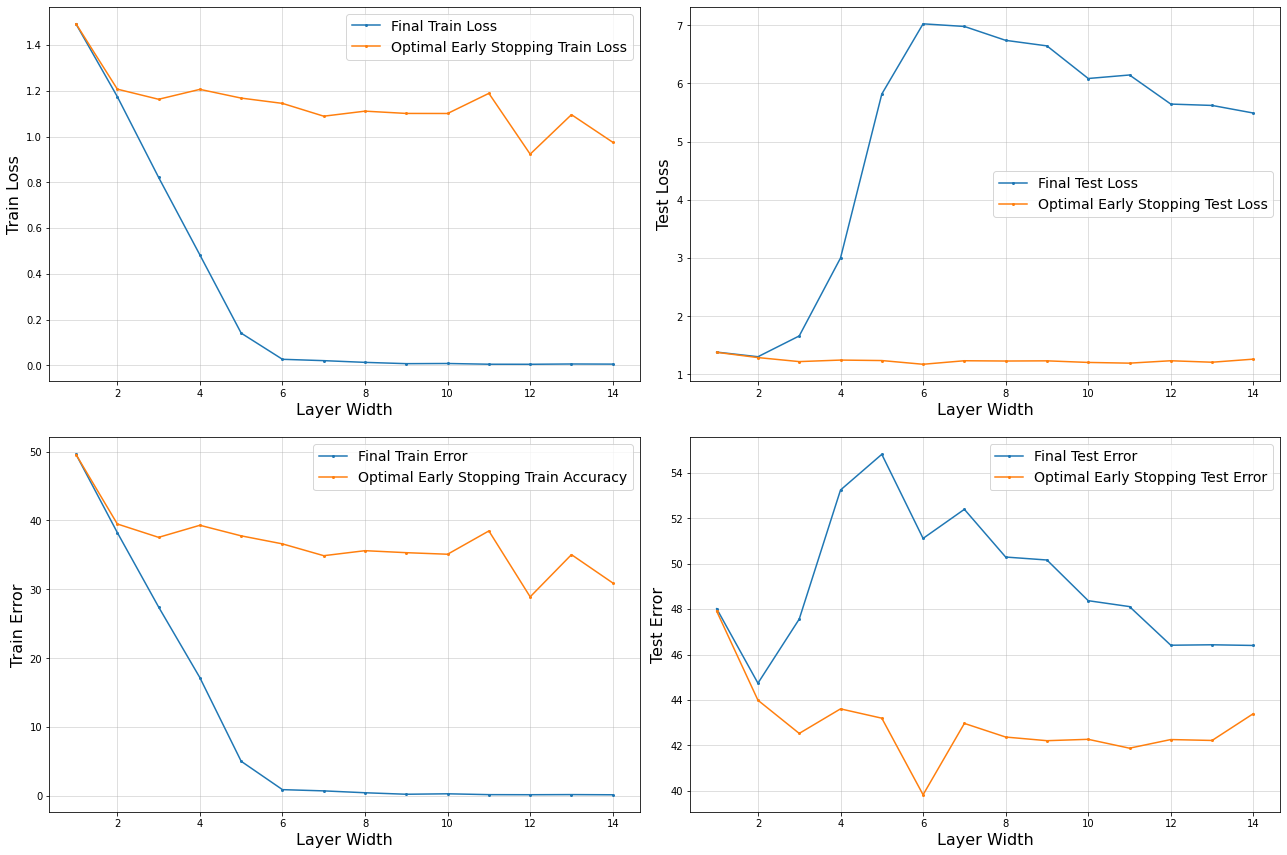

In [44]:
plot_loss_from_file("experimental_results_cifar10/resnet18_10pct_noise_alpha_1_Pres_Bathch_Norm_Results.pkl")